In [163]:
# import libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
# Show plots in the notebook
%matplotlib inline

In [164]:
# problem1

In [165]:
# import data
data = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")

# check data
data

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [166]:
# slice the area needed (5N-5S, 170W-120W)
data = data.sel(lat=slice(-5,5), lon=slice(190, 240))

# check data
data

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 26, time: 684)
Coordinates:
  * lat      (lat) float32 -4.0 -2.0 0.0 2.0 4.0
  * lon      (lon) float32 190.0 192.0 194.0 196.0 ... 234.0 236.0 238.0 240.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [167]:
# check null values
data.isnull().sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    sst      int32 0

In [168]:
# calculate the mean of the data according to time
mean_time = data.mean(dim=['lat', 'lon'])

#check mean_time
mean_time

<xarray.Dataset>
Dimensions:  (time: 684)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time) float32 26.25 26.27 26.97 27.51 ... 26.1 25.82 25.72 25.76

In [169]:
# calculate the mean of the data according to month
mean_month = mean_time.groupby('time.month').mean()

# check result
mean_month

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month) float32 26.57 26.74 27.24 27.69 ... 26.74 26.72 26.69 26.61

In [170]:
# find the anomalies
anomalies =mean_time.groupby('time.month') - mean_month

# check result
anomalies

<xarray.Dataset>
Dimensions:  (time: 684)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time) float32 -0.3196 -0.4685 -0.2682 ... -0.8967 -0.9708 -0.8553

In [171]:
# calculate the rolling mean
mean_rolling = anomalies.rolling(time=3, center=True, min_periods=1).mean()

# check result
mean_rolling

<xarray.Dataset>
Dimensions:  (time: 684)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time) float32 -0.3941 -0.3521 -0.3079 ... -0.8358 -0.9076 -0.913

In [172]:
# transform to dataframe to plot, I am inspired by my roommate Zhouzhou
tf = mean_rolling.to_dataframe().reset_index()
anomalies_df = anomalies.to_dataframe().reset_index()

# check  result
tf

,time,month,sst
0,1960-01-15,1,-0.394051
1,1960-02-15,2,-0.352084
2,1960-03-15,3,-0.307880
3,1960-04-15,4,-0.210906
4,1960-05-15,5,-0.240752
...,...,...,...
679,2016-08-15,8,-0.618387
680,2016-09-15,9,-0.728148
681,2016-10-15,10,-0.835824
682,2016-11-15,11,-0.907570


In [173]:
# add rolling mean column and check result
anomalies_df['mean_rolloing'] = tf['sst']
anomalies_df

,time,month,sst,mean_rolloing
0,1960-01-15,1,-0.319580,-0.394051
1,1960-02-15,2,-0.468521,-0.352084
2,1960-03-15,3,-0.268152,-0.307880
3,1960-04-15,4,-0.186966,-0.210906
4,1960-05-15,5,-0.177599,-0.240752
...,...,...,...,...
679,2016-08-15,8,-0.647745,-0.618387
680,2016-09-15,9,-0.640022,-0.728148
681,2016-10-15,10,-0.896675,-0.835824
682,2016-11-15,11,-0.970774,-0.907570


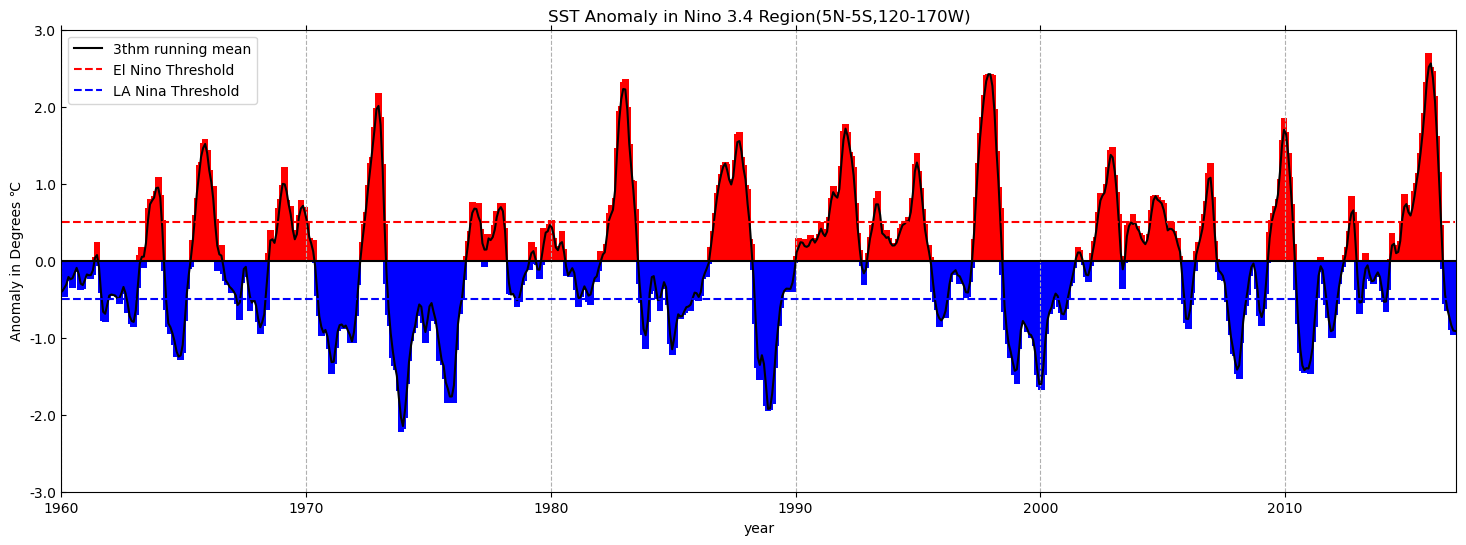

In [181]:
plt.figure(figsize=(18,6))

# adjust the color
colour = np.where(anomalies_df['sst']>0, 'red', 'blue')

# plot bar chart
#Zhouzhou inspired me to adjust the width
plt.bar(anomalies_df['time'], anomalies_df['sst'], width=100, color=colour)

#plot rolling_mean 
plt.plot(anomalies_df['time'],anomalies_df['mean_rolloing'], color='black',label='3thm running mean')

#plot the zero and threshold line 
plt.plot(anomalies_df['time'],np.zeros(684),color='black')
plt.plot(anomalies_df['time'],np.zeros(684)+0.5,color='red', linestyle='--',label='El Nino Threshold')
plt.plot(anomalies_df['time'],np.zeros(684)-0.5,color='blue', linestyle='--',label='LA Nina Threshold')

# adjust the label and ticks
# set label
plt.xlabel('year')
plt.ylabel('Anomaly in Degrees ℃')

#set ticks
y = [-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0]
plt.yticks(y,labels=y)
plt.xlim(datetime(1960,1,1),datetime(2016,12,31))
#plot title
plt.title('SST Anomaly in Nino 3.4 Region(5N-5S,120-170W)')

#plot grid
plt.grid(linestyle='--',axis='x')
plt.xlim()

#tick parameter
plt.tick_params(axis='y',left=True,direction='in',which='both')
plt.tick_params(axis='x',top=True,bottom=True,direction='out',which='both')
plt.legend()

In [162]:
# problem2